## **Imports and Configurations**

In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt

import ast
import torch
import spacy
import transformers

from utils import loader
from utils import models
from utils.train import train
from utils.eval import eval
from collections import Counter

c:\Users\luwul\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
essays, prompts = loader.load_data()

## **Analyzing the data**

C:\Users\luwul\AppData\Local\Temp\ipykernel_7160\2061115511.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=paragraph_count, palette='viridis')


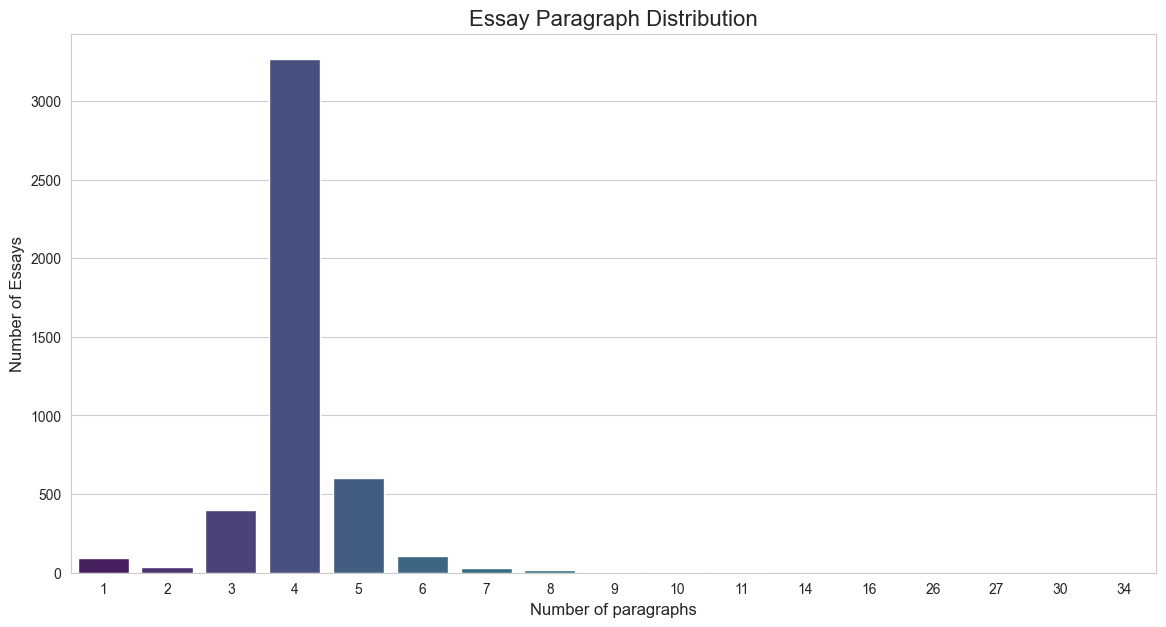

In [3]:
paragraph_count = []

for row in essays['essay']:
    paragraph_count.append(len(ast.literal_eval(row)))

paragraph_count = Counter(paragraph_count)

sns.set_style("whitegrid")

plt.figure(figsize=(14, 7))
sns.barplot(data=paragraph_count, palette='viridis')
plt.title('Essay Paragraph Distribution', fontsize=16)
plt.xlabel('Number of paragraphs', fontsize=12)
plt.ylabel('Number of Essays', fontsize=12)

plt.show()

## **Approach 1: BERTimbaum Embeddings + Class Head**

In [4]:
from transformers import pipeline
from utils.loader import categorize_score


tokenizer = transformers.AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = transformers.AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

extractor = pipeline(
        "feature-extraction",
        model=model,
        tokenizer=tokenizer,
        framework="pt"
    )

text_embeddings = []
text_labels = []

for index, row in essays[:100].iterrows():
    text = ast.literal_eval(row['essay'])

    paragraph_embeddings = []
    for paragraph in text:
        paragraph_embeddings.append(np.mean(extractor(paragraph)[0], axis=0))

    text_embeddings.append(paragraph_embeddings)
    text_labels.append(categorize_score(ast.literal_eval(row['competence'])[4]))




max_len = max(len(e) for e in text_embeddings)
hidden_size = model.config.hidden_size
padded_embeddings = [e + [np.zeros(hidden_size, dtype=np.float32)] * (max_len - len(e)) for e in text_embeddings]

W0625 16:13:22.711914 7160 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [5]:
train_loader, test_loader = loader.embeddings_into_dataloader(
    np.array([np.concatenate(e) for e in padded_embeddings]), 
    np.array(text_labels)
    )
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = max_len * hidden_size

classHead = models.ClassificationHead(input_size=input_size, targets=6)
print(f"\nModel architecture:\n{classHead}")


Model architecture:
ClassificationHead(
  (fc): Sequential(
    (0): Linear(in_features=8448, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)


In [ ]:

train(model=classHead, train_loader=train_loader, device=device, num_epochs=50, lr=1e-4)


--- Starting Training ---
|-> Epoch [1/50], Loss: 6.7330, Train Accuracy: 0.2250
|-> Epoch [2/50], Loss: 5.4694, Train Accuracy: 0.4375
|-> Epoch [3/50], Loss: 4.7433, Train Accuracy: 0.6000
|-> Epoch [4/50], Loss: 4.4065, Train Accuracy: 0.5250
|-> Epoch [5/50], Loss: 3.8987, Train Accuracy: 0.6000
|-> Epoch [6/50], Loss: 3.4102, Train Accuracy: 0.6500
|-> Epoch [7/50], Loss: 2.9197, Train Accuracy: 0.8125
|-> Epoch [8/50], Loss: 2.7802, Train Accuracy: 0.7625
|-> Epoch [9/50], Loss: 2.2109, Train Accuracy: 0.8500
|-> Epoch [10/50], Loss: 2.4141, Train Accuracy: 0.8375
|-> Epoch [11/50], Loss: 1.7098, Train Accuracy: 0.9125
|-> Epoch [12/50], Loss: 1.6094, Train Accuracy: 0.8875
|-> Epoch [13/50], Loss: 1.5834, Train Accuracy: 0.8750
|-> Epoch [14/50], Loss: 1.2119, Train Accuracy: 0.9500
|-> Epoch [15/50], Loss: 1.2350, Train Accuracy: 0.9125
|-> Epoch [16/50], Loss: 1.0342, Train Accuracy: 0.9375
|-> Epoch [17/50], Loss: 0.9470, Train Accuracy: 0.9500
|-> Epoch [18/50], Loss: 0.903

In [7]:

eval(model=classHead, test_loader=test_loader, device=device)


--- Evaluation on Test Set ---
Final Test Accuracy: 0.4500
Final Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         1
           2       0.40      0.33      0.36         6
           3       0.58      0.88      0.70         8
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         2

    accuracy                           0.45        20
   macro avg       0.16      0.20      0.18        20
weighted avg       0.35      0.45      0.39        20



## **Approach 2: Feature Selection > BERTimbaum Embeddings + Class Head**

In [ ]:
spacy_pipeline = spacy.load("pt_core_news_sm")

sample = ast.literal_eval(essays['essay'][1])


for paragraph in sample:
    tokens = spacy_pipeline(paragraph)
    display(tokens.ents)